# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

A list of the imports, i.e. libraries used throughout the code

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from collections import defaultdict
%matplotlib inline

In [3]:
DATA_FOLDER = 'Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

The Ebola dataset that we had to handle was a very noisy dataset. The dataset consists of CSV files, referring to different countries and different dates of the virus spread. The data itself is records for specific towns of each country describing cases,deaths,etc. and our objective is to find the mean value of new cases and deaths per day for each month. Due to the dirty nature of the dataset we had to implement some data wrangling techniques. The problems which have been observed vary. NaN values or fields with no records,inconsistent values between totals and factors of the totals, similar/identical csv files for different days records, redundant records as far as the mean of new cases and deaths concern, lack of sufficient data for each month (e.g 5 daysreport/month),different descriptions over the records referring to same situations, long representation of the data-unhierarchical representation. We tried to solve most of them in an efficient way (imputation,reshaping,pivoting,aggregations...) and for that reason we did some assumptions over the data.

In [3]:
EBOLA_DATA_FOLDER = DATA_FOLDER + '/ebola'

#List all files of each country to a seperate list of csv's
COUNTRY_DATA_FOLDER = EBOLA_DATA_FOLDER + "/guinea_data/"
guinea_datafiles = [COUNTRY_DATA_FOLDER + gf for gf in os.listdir(COUNTRY_DATA_FOLDER)]
COUNTRY_DATA_FOLDER = EBOLA_DATA_FOLDER + "/liberia_data/"
liberia_datafiles = [COUNTRY_DATA_FOLDER+ lf for lf in os.listdir(COUNTRY_DATA_FOLDER)]
COUNTRY_DATA_FOLDER = EBOLA_DATA_FOLDER + "/sl_data/"
sl_datafiles = [COUNTRY_DATA_FOLDER + slf for slf in os.listdir(COUNTRY_DATA_FOLDER)]

#Sort csv's according the name of the files -> sort by date
guinea_datafiles.sort()
liberia_datafiles.sort()
sl_datafiles.sort()

#print (guinea_datafiles)

data_dict = {'guinea':guinea_datafiles, 'liberia':liberia_datafiles, 'sl':sl_datafiles}

#We will iterate through each country (dict) so we can process the data

for key, value in data_dict.items():
    if key == 'guinea':
        #guinea code - value in this case is the list of the guinea dataset
        print("Guinea Processing...")
        #Convert the list of files in list of Dataframes of the files
        guinea_dfr = [pd.read_csv(dfile,parse_dates=['Date']).copy() for dfile in value]
        #print (type(guinea_dfr)) + (type(guinea_dfr[0])) -> Proof of dataframe list   
    elif key == 'liberia':
        #liberia code - value in this case is the list of the liberia dataset
        print("Liberia Processing...")
        liberia_dfr = [pd.read_csv(dfile,parse_dates=['Date']).copy() for dfile in value]    
    elif key == 'sl':
        #siera_leone code - value in this case is the list of the siera leone dataset
        print("Siera Leone processing")
        sl_dfr = [pd.read_csv(dfile,parse_dates=['date']).copy() for dfile in value]
    else:
        print(err,"Unknown dataset")

#We are planning to change the dataframes so this is the reason of copy() methods

Guinea Processing...
Liberia Processing...
Siera Leone processing


So the CSV files were imported into multiple Dataframes for processing before they will be concatenated in a single one. Now because we care about the daily average of each month we should split the list of each country according the month that the records took place.

In [4]:
month_calendar_g = defaultdict(list)
month_calendar_l = defaultdict(list)
month_calendar_s = defaultdict(list)

for dfr_iter in guinea_dfr:
    dfr_iter.columns = map(str.upper,dfr_iter.columns) #We transform every column name into uppercase to have the same format
    month_calendar_g[dfr_iter.DATE.dt.month.head(1)[0]].append(dfr_iter)
for dfr_iter in liberia_dfr:
    dfr_iter.columns = map(str.upper,dfr_iter.columns) #We transform every column name into uppercase to have the same format
    month_calendar_l[dfr_iter.DATE.dt.month.head(1)[0]].append(dfr_iter)
for dfr_iter in sl_dfr:
    dfr_iter.columns = map(str.upper,dfr_iter.columns) #We transform every column name into uppercase to have the same format
    month_calendar_s[dfr_iter.DATE.dt.month.head(1)[0]].append(dfr_iter)

#print (month_calendar)

So now this month calendar dictionary has in every 'key',( which represents a month of a year) a list of dataframes with records that correspond to 'key' month. So in this way we splitted the CSV files of the dataset to their corresponding month. Now we will manage each non-empty item of the month_calendar to find the result for each month.

<u><b>Assumption 1</b></u> <br></br> Dropping NaN Values: In some dataset files there are redundant columns with no data at all (all values are NaN) so we want to remove such columns as they dont have any meaning to our measurements.

In [5]:
for key,value in month_calendar_g.items():
    for df in value:
        df.dropna(axis=1,how='all',inplace=True)
        
for key,value in month_calendar_l.items():
    for df in value:
        df.dropna(axis=1,how='all',inplace=True)
        
for key,value in month_calendar_s.items():
    for df in value:
        df.dropna(axis=1,how='all',inplace=True)

<u><b>Assumption 2</b></u> <br></br> Zero's Imputation: After we have the data files clean from empty columns -> of towns without data at all we assume that the rest of the data values that are NaN can be represented as Zeros in our dataset as we cannot assume anything about them. Maybe we could imputate them with the mean value of the other field that correspond to them, but this is not obvious that should happening and it might lead to oversanitizing.

In [6]:
for key,value in month_calendar_g.items():
    print(len(value))
    for df in value:
        print (df)
        df.fillna(value = int(0),inplace=True)


5
         DATE                                        DESCRIPTION  TOTALS  \
0  2014-08-04                              New cases of suspects       5   
1  2014-08-04                             New cases of probables       0   
2  2014-08-04                             New cases of confirmed       4   
3  2014-08-04                  Total new cases registered so far       9   
4  2014-08-04                            Total cases of suspects      11   
5  2014-08-04                           Total cases of probables     133   
6  2014-08-04                           Total cases of confirmed     351   
7  2014-08-04       Cumulative (confirmed + probable + suspects)     495   
8  2014-08-04                        New deaths registered today       2   
9  2014-08-04            New deaths registered today (confirmed)       2   
10 2014-08-04            New deaths registered today (probables)       0   
11 2014-08-04             New deaths registered today (suspects)       0   
12 2014-08

         DATE                                      DESCRIPTION TOTALS CONAKRY  \
0  2014-09-07                            New cases of suspects      5     NaN   
1  2014-09-07                           New cases of probables      0     NaN   
2  2014-09-07                           New cases of confirmed     11     NaN   
3  2014-09-07                Total new cases registered so far     16       0   
4  2014-09-07                          Total cases of suspects     32      10   
5  2014-09-07                         Total cases of probables    151       8   
6  2014-09-07                         Total cases of confirmed    678     113   
7  2014-09-07     Cumulative (confirmed + probable + suspects)    861     131   
8  2014-09-07                  Total suspected non-class cases    714     246   
9  2014-09-07                            New deaths registered      4     NaN   
10 2014-09-07                         Total deaths of suspects      4       2   
11 2014-09-07               

         DATE                                      DESCRIPTION TOTALS CONAKRY  \
0  2014-09-17                            New cases of suspects      4       3   
1  2014-09-17                           New cases of probables      0     NaN   
2  2014-09-17                           New cases of confirmed      6       2   
3  2014-09-17                Total new cases registered so far     10       5   
4  2014-09-17                          Total cases of suspects     32      14   
5  2014-09-17                         Total cases of probables    161       8   
6  2014-09-17                         Total cases of confirmed    771     129   
7  2014-09-17     Cumulative (confirmed + probable + suspects)    964     151   
8  2014-09-17                  Total suspected non-class cases    787     278   
9  2014-09-17                            New deaths registered      3     NaN   
10 2014-09-17                         Total deaths of suspects      5       2   
11 2014-09-17               


<u><b>Assumption 3</b></u> <br></br> Similarity Extermination: We have noticed that some CSV files in the same month are the same or mostly identical to one another. So we assume that these CSV files correspond to the same report but there was a mistake during the formation of the dataset, because we believe that is impossible two reports of two different days, sometimes even with a 1-day difference to have the same values and features for all the fields. Some examples are (2014-09-07 & 2014-09-08 or 2014-09-16 & 2014/09/17) on Guinea dataset. Our goal is to find these kind of CSV files checking tuples of succesively CSV files.

In [7]:
THRESHOLD = 99.0
deleted_items = []
for key,value in month_calendar_g.items():
    for elem in range(len(value)-1):
        if(len(value[elem].columns) == len(value[elem+1].columns)):
            if(len(value[elem].index) == len(value[elem+1].index)):
                comp_arrays = value[elem][value[elem].columns[1:]].values == value[elem + 1][value[elem+1].columns[1:]].values
                print (value[elem].DATE.dt.day.head(1)[0],"/",value[elem].DATE.dt.month.head(1)[0],"vs",value[elem+1].DATE.dt.day.head(1)[0],"/",value[elem+1].DATE.dt.month.head(1)[0])
                print ("True:",np.count_nonzero(comp_arrays),"False",np.size(comp_arrays)-np.count_nonzero(comp_arrays))
                if(np.count_nonzero(comp_arrays)/np.size(comp_arrays)*100 > THRESHOLD):
                    #value[elem].combine_first(value[elem+1])
                    deleted_items.append((key,elem+1))
                    print("Similarity")

for i in deleted_items:
    del month_calendar_g[i[0]][i[1]] #Delete the same csv files that were found in previous step

for key,value in month_calendar_g.items():
    print (len(value))

deleted_items = []
for key,value in month_calendar_l.items():
    for elem in range(len(value)-1):
        if(len(value[elem].columns) == len(value[elem+1].columns)):
            if(len(value[elem].index) == len(value[elem+1].index)):
                comp_arrays = value[elem][value[elem].columns[1:]].values == value[elem + 1][value[elem+1].columns[1:]].values
                print (value[elem].DATE.dt.day.head(1)[0],"/",value[elem].DATE.dt.month.head(1)[0],"vs",value[elem+1].DATE.dt.day.head(1)[0],"/",value[elem+1].DATE.dt.month.head(1)[0])
                print ("True:",np.count_nonzero(comp_arrays),"False",np.size(comp_arrays)-np.count_nonzero(comp_arrays))
                if(np.count_nonzero(comp_arrays)/np.size(comp_arrays)*100 > THRESHOLD):
                    #value[elem].combine_first(value[elem+1])
                    deleted_items.append((key,elem+1))
                    print("Similarity")

for i in deleted_items:
    del month_calendar_l[i[0]][i[1]] #Delete the same csv files that were found in previous step

for key,value in month_calendar_l.items():
    print (len(value))

deleted_items = []
for key,value in month_calendar_s.items():
    for elem in range(len(value)-1):
        if(len(value[elem].columns) == len(value[elem+1].columns)):
            if(len(value[elem].index) == len(value[elem+1].index)):
                comp_arrays = value[elem][value[elem].columns[1:]].values == value[elem + 1][value[elem+1].columns[1:]].values
                print (value[elem].DATE.dt.day.head(1)[0],"/",value[elem].DATE.dt.month.head(1)[0],"vs",value[elem+1].DATE.dt.day.head(1)[0],"/",value[elem+1].DATE.dt.month.head(1)[0])
                print ("True:",np.count_nonzero(comp_arrays),"False",np.size(comp_arrays)-np.count_nonzero(comp_arrays))
                if(np.count_nonzero(comp_arrays)/np.size(comp_arrays)*100 > THRESHOLD):
                    #value[elem].combine_first(value[elem+1])
                    deleted_items.append((key,elem+1))
                    print("Similarity")

for i in deleted_items:
    del month_calendar_s[i[0]][i[1]] #Delete the same csv files that were found in previous step

for key,value in month_calendar_s.items():
    print (len(value))

26 / 8 vs 27 / 8
True: 235 False 277
30 / 8 vs 31 / 8
True: 454 False 90
2 / 9 vs 4 / 9
True: 482 False 126
4 / 9 vs 7 / 9
True: 452 False 156
7 / 9 vs 8 / 9
True: 606 False 2
Similarity
8 / 9 vs 9 / 9
True: 509 False 99
9 / 9 vs 11 / 9
True: 488 False 120
14 / 9 vs 16 / 9
True: 503 False 137
16 / 9 vs 17 / 9
True: 639 False 1
Similarity
17 / 9 vs 19 / 9
True: 525 False 115
21 / 9 vs 22 / 9
True: 601 False 71
26 / 9 vs 30 / 9
True: 546 False 158
5
14
1
16 / 6 vs 17 / 6
True: 85 False 39
17 / 6 vs 22 / 6
True: 61 False 63
22 / 6 vs 24 / 6
True: 69 False 55
28 / 6 vs 29 / 6
True: 364 False 39
1 / 7 vs 2 / 7
True: 344 False 59
2 / 7 vs 3 / 7
True: 357 False 46
3 / 7 vs 7 / 7
True: 332 False 71
7 / 7 vs 8 / 7
True: 358 False 45
8 / 7 vs 10 / 7
True: 332 False 71
10 / 7 vs 13 / 7
True: 301 False 102
13 / 7 vs 17 / 7
True: 245 False 158
17 / 7 vs 20 / 7
True: 268 False 135
20 / 7 vs 24 / 7
True: 254 False 149
24 / 7 vs 26 / 7
True: 305 False 98
17 / 8 vs 18 / 8
True: 87 False 285
1 / 9 vs 2 

From the previous result is obvious that datasets with minor number of false compared values have high correlation between them and they are identical. We can now assume a threshold with which we can combine the two datasets into one. We think that the best procedure for that would be the combine_first method, in order to complete the data of month_concat_listone of the two datasets but the imputation has already taken place and the information loss is low due to high similarity.

In [8]:
#We will concat the datasets of the same month
month_concat_list_g = []
for key,value in month_calendar_g.items():
    month_concat_list_g.append(pd.concat(value,ignore_index = True))

for i in month_concat_list_g:
    i.dropna(axis=1,how='all',inplace=True)
    i.fillna(value=0, inplace=True)
month_concat_list_g[0]

,BOFFA,CONAKRY,DABOLA,DATE,DESCRIPTION,DINGUIRAYE,DUBREKA,FORECARIAH,GUECKEDOU,KISSIDOUGOU,KOUROUSSA,MACENTA,MZEREKORE,NZEREKORE,PITA,SIGUIRI,TELIMELE,TOTALS,YOMOU
0,0,5,0,2014-08-04,New cases of suspects,0,0,0,0,0,0,0,0,0,0,0,0,5,0
1,0,0,0,2014-08-04,New cases of probables,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,2014-08-04,New cases of confirmed,0,0,0,3,0,0,0,0,0,0,0,0,4,0
3,0,6,0,2014-08-04,Total new cases registered so far,0,0,0,3,0,0,0,0,0,0,0,0,9,0
4,0,9,0,2014-08-04,Total cases of suspects,0,0,0,2,0,0,0,0,0,0,0,0,11,0
5,5,8,3,2014-08-04,Total cases of probables,1,0,0,95,4,2,11,0,0,1,0,3,133,0
6,18,78,1,2014-08-04,Total cases of confirmed,0,0,0,188,2,2,28,0,4,1,6,23,351,0
7,23,95,4,2014-08-04,Cumulative (confirmed + probable + suspects),1,0,0,285,6,4,39,0,4,2,6,26,495,0
8,0,0,0,2014-08-04,New deaths registered today,0,0,0,2,0,0,0,0,0,0,0,0,2,0
9,0,0,0,2014-08-04,New deaths registered today (confirmed),0,0,0,2,0,0,0,0,0,0,0,0,2,0



<u><b>Assumption 4</b></u> <br></br> Inconsistent Values: In our data we have observed that there are differences between the 'Totals' field and the fields that are the factors of this sum. We assume that the error in dataset is more likely to happened due to an error in the calculation (addition) of the data, as we think is much more difficult for the report of each town to be wrong in the manner ,that the observations of the affected people and the deaths are more or less trivial for the human, who write the report. In this case we base our assumption in an accumulation error for the sum. We face that as shown below:

In [9]:
for i in month_concat_list_g:
    i[i.columns.difference(['DATE','DESCRIPTION'])] = i[i.columns.difference(['DATE','DESCRIPTION'])].replace('%','',regex=True,).astype('int')
    row_sum = i[i.columns.difference(['TOTALS', 'DATE','DESCRIPTION'])].apply(lambda row: np.sum(row),axis=1)
    smax = np.maximum(i['TOTALS'], row_sum)
    i['TOTALS'] = smax.values

<u><b>Assumption 5</b></u> <br></br>
For finding the mean value for our dataset we just need the total amounts (as we trust their accuracy) and in this way we can drop the columns of the towns that provide us the total amounts as they are no usefull no more.

In [10]:
for i in month_concat_list_g:
    i.drop(i.columns.difference(['TOTALS', 'DATE','DESCRIPTION']), axis=1, inplace=True)
    i

<u><b>Assumption 6</b></u> <br></br>
We also want to exclude some records of the dataset as we care only about the new cases and deaths and not every possible record. So we will compile a regex that will match the wanted data.

In [11]:
regex_g =re.compile(r'\b[Nn]ew\s[Cc]ases\s(?!of)registered(?!among)|[Nn]ew\s[Dd]eaths(?!of)\sregistered\s(?!among)\b',flags=re.IGNORECASE)

for i in month_concat_list_g:
    print (i['DESCRIPTION'])
    i['DESCRIPTION'] = i['DESCRIPTION'].apply(lambda x: re.findall(regex_g,x))
   # print (i['DESCRIPTION'])


0                                New cases of suspects
1                               New cases of probables
2                               New cases of confirmed
3                    Total new cases registered so far
4                              Total cases of suspects
5                             Total cases of probables
6                             Total cases of confirmed
7         Cumulative (confirmed + probable + suspects)
8                          New deaths registered today
9              New deaths registered today (confirmed)
10             New deaths registered today (probables)
11              New deaths registered today (suspects)
12                            Total deaths of suspects
13                           Total deaths of probables
14                           Total deaths of confirmed
15     Total deaths (confirmed + probables + suspects)
16                              Total PEC center today
17                  Total PEC center today (confirmed)
18        

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

The first step is to import the required data from each of the ten different files. Since the provided data is in .xls format, a good option is to use the `read_excel` function that pandas provides, for importing Excel spreadsheets. The file names follow a convenient convention that allows for reading in the data in a for loop. 

The `dataset_array` variable is just a regular Python array that stores the imported `DataFrame`s temporarily, until they are merged into a single `DataFrame`.

In [8]:
MICROBIOME_DATA_FOLDER = DATA_FOLDER + '/microbiome'

# Generate the numbers from 1 to 9, which are helpful for creating the file names of the datasets
file_indices = range(1,10)
# A temporary array for storing the DataFrames
dataset_array = [None] * len(file_indices) 
metadata = pd.read_excel(('%s/%s') % (MICROBIOME_DATA_FOLDER, 'metadata.xls'), 'Sheet1', index_col=0, header=0)
for file_index in file_indices:
    file_name = 'MID%d.xls' % file_index # Constructs the name of the file which needs to be imported
    full_path = '%s/%s' % (MICROBIOME_DATA_FOLDER, file_name) # Appends the folder structure to the file name
    dataset_array[file_index - 1] = pd.read_excel(full_path, 'Sheet 1', index_col=0, header=None)
    
dataset_array

[                                                       1
 0                                                       
 Archaea "Crenarchaeota" Thermoprotei Desulfuroc...     7
 Archaea "Crenarchaeota" Thermoprotei Desulfuroc...     2
 Archaea "Crenarchaeota" Thermoprotei Sulfolobal...     3
 Archaea "Crenarchaeota" Thermoprotei Thermoprot...     3
 Archaea "Euryarchaeota" "Methanomicrobia" Metha...     7
 Archaea "Euryarchaeota" "Methanomicrobia" Metha...     1
 Archaea "Euryarchaeota" "Methanomicrobia" Metha...     1
 Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...     1
 Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...     1
 Archaea "Euryarchaeota" Halobacteria Halobacter...     1
 Archaea "Euryarchaeota" Halobacteria Halobacter...     4
 Archaea "Euryarchaeota" Halobacteria Halobacter...     1
 Archaea "Euryarchaeota" Halobacteria Halobacter...     2
 Archaea "Euryarchaeota" Halobacteria Halobacter...     4
 Archaea "Euryarchaeota" Methanococci Methanococ...     1
 Archaea "Eury

Another for loop to go over the imported `DataFrame`s from the different files and append the columns to form a single dataset. This is done by concatenating each DataFrame as an additional column to the `concat_ds` variable, based on the indices which are the taxon names of the archaea and bacteria. An outer join is performed in order to keep the all the rows from both tables, even if there isn't a matching counterpart (there might be one at a later stage, i.e. in another `DataFrame`).

In [9]:
concat_ds = dataset_array[0]
for table in range(1,len(dataset_array)):
    concat_ds = pd.concat([concat_ds, dataset_array[table]], axis=1, join='outer')

concat_ds.head(10)

,1,1,1,1,1,1,1,1,1
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Acidilobaceae Acidilobus",NaN,2.0,1.0,NaN,5.0,NaN,NaN,NaN,NaN
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Caldisphaeraceae Caldisphaera",NaN,14.0,15.0,NaN,26.0,NaN,1.0,NaN,1.0
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera",7.0,23.0,14.0,2.0,28.0,7.0,8.0,NaN,16.0
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Stetteria",NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Sulfophobococcus",NaN,1.0,4.0,NaN,5.0,1.0,2.0,NaN,2.0
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Thermodiscus",NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Thermosphaera",NaN,2.0,1.0,NaN,2.0,NaN,1.0,NaN,NaN
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Hyperthermus",NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Pyrodictium",NaN,NaN,3.0,NaN,2.0,1.0,1.0,NaN,5.0
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Pyrolobus",2.0,2.0,NaN,NaN,3.0,2.0,1.0,NaN,NaN


Each missing value in the dataset should be replaced by the keyword `unknown`.

In [10]:
concat_ds = concat_ds.fillna('unknown')
# concat_ds.index.name = 'Taxon'

concat_ds.head(10)

,1,1,1,1,1,1,1,1,1
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Acidilobaceae Acidilobus",unknown,2,1,unknown,5,unknown,unknown,unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Caldisphaeraceae Caldisphaera",unknown,14,15,unknown,26,unknown,1,unknown,1
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera",7,23,14,2,28,7,8,unknown,16
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Stetteria",unknown,unknown,unknown,unknown,1,unknown,unknown,unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Sulfophobococcus",unknown,1,4,unknown,5,1,2,unknown,2
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Thermodiscus",unknown,unknown,1,unknown,unknown,unknown,unknown,unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Thermosphaera",unknown,2,1,unknown,2,unknown,1,unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Hyperthermus",unknown,1,unknown,unknown,unknown,unknown,unknown,unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Pyrodictium",unknown,unknown,3,unknown,2,1,1,unknown,5
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Pyrolobus",2,2,unknown,unknown,3,2,1,unknown,unknown


According to the semantics of the index column in the data frame, it is safe to assume that it is unique over the entire dataset contained in one file and that across multiple files the same organism will be identified by the same index, since it is a list of archaea and bacteria names based on their taxon hierarchical classification.

Nevertheless, the uniqueness of indices in a dataframe can be easily checked.

In [11]:
concat_ds.index.is_unique

True

Next would be to append the metadata to the `DataFrame` as column titles. Since the metadata consists of three pieces of information for each file (which corresponds to one column), there will be three levels of hierarchy in the column indexing.

The first level index is `Sample`, whether the sample is taken from a tissue or from the stool. This allows for a nice grouping of the data since there are only three possible values for this attribute. That's what makes it convenient for it to be a first-level index.

The second column index level is `Group`, which indicates whether the sample has been taken from a healthy tissue (control) or not.

The third index level is the `Barcode` that actually corresponds to the file names from where the data was imported.

In [12]:
level1 = list(metadata.iloc[:,1].fillna('unknown'))
level2 = list(metadata.iloc[:,0])
level3 = list(metadata.index)

metadata_columns = list(metadata.columns)
column_indices = pd.MultiIndex.from_arrays([level1, level2, level3], 
                                           names=[metadata_columns[1], metadata_columns[0], metadata.index.name])
concat_ds.columns = column_indices
concat_ds.head(10)

SAMPLE                                                        unknown  \
GROUP                                              EXTRACTION CONTROL   
BARCODE                                                          MID1   
Archaea "Crenarchaeota" Thermoprotei Acidilobal...            unknown   
Archaea "Crenarchaeota" Thermoprotei Acidilobal...            unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...                  7   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...            unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...            unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...            unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...            unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...            unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...            unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...                  2   

SAMPLE                                               tissue            \
GROUP                                                 NEC 1 Control 1   
BARCODE                                                MID2      MID3   
Archaea "Crenarchaeota" Thermoprotei Acidilobal...        2         1   
Archaea "Crenarchaeota" Thermoprotei Acidilobal...       14        15   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...       23        14   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown   unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...        1         4   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown         1   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...        2         1   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...        1   unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown         3   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...        2   unknown   

SAMPLE                                                                 \
GROUP                                                 NEC 2 Control 2   
BARCODE                                                MID4      MID5   
Archaea "Crenarchaeota" Thermoprotei Acidilobal...  unknown         5   
Archaea "Crenarchaeota" Thermoprotei Acidilobal...  unknown        26   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...        2        28   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown         1   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown         5   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown   unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown         2   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown   unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown         2   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown         3   

SAMPLE                                                stool            \
GROUP                                                 NEC 1 Control 1   
BARCODE                                                MID6      MID7   
Archaea "Crenarchaeota" Thermoprotei Acidilobal...  unknown   unknown   
Archaea "Crenarchaeota" Thermoprotei Acidilobal...  unknown         1   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...        7         8   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown   unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...        1         2   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown   unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown         1   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown   unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...        1         1   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc...        2         1   

SAMPLE                                                                 
GROUP                                                 NEC 2 Control 2  
BARCODE                                                M

This way of column multilevel indexing allows for a very easy and convenient way of generating subsets of the data, based on any column name which can be on any of the three levels. The following example demonstrates just that.

In [13]:
concat_ds.xs(key="Control 1", axis=1, level="GROUP").head(10)

SAMPLE,tissue,stool
BARCODE,MID3,MID7
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Acidilobaceae Acidilobus",1,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Caldisphaeraceae Caldisphaera",15,1
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera",14,8
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Stetteria",unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Sulfophobococcus",4,2
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Thermodiscus",1,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Thermosphaera",1,1
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Hyperthermus",unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Pyrodictium",3,1


## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [4]:
from IPython.core.display import HTML
HTML(filename="Data"+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [5]:
data=pd.read_excel('Data/titanic.xls')
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [6]:
data.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

There are a total of 14 attributes:
1. Name
    * object (string)
2. Ticket
    * object (string)
3. Pclass
    * integer, *should be categorical (ordinal)*
    * 1st, 2nd, 3rd class
4. Survived
    * integer, *should be categorical (nominal)*
    * 0=No, 1=Yes
5. Sex
    * object (string) *should be categorical (nominal)*
    * female, male
6. Age
    * float, *discretization might be usefull*
    * [0.166700, 80]
    * has 263 missing values
7. Sibsp
    * int
    * [0,8]
8. Parch
    * int
    * [0, 9]
9. Fare
    * float
    * [0, 512.329200]
    * has 1 missing values
10. Cabin
    * object (string), *spliting on two attributes deck (categorical,ordinal) and room number (numeric) might be usfull)*
    * has 1014 missing values
11. Embarked
    * object (string), *should be categorical (nominal)*
    * S, C, Q
    * has 2 missing values
12. Boat
    * object (string)
    * [1, 16], [A-D]
    * has 823 missing values
13. Body
    * float, *should be int since it has only integer values*
    * [1, 328]
    * has 1118 missing values
14. Home.dest
    * object (string)
    * has 564 missing values

Since we've discussed the range of the attributes and determined the categorical ones, now we will focus on their ordering.

The attribute `pclass` is ordered, since being in a higher class has more benefits than being in a lower one. The other three categorical attributes are not inherently ordered, hence they will be unordered (nominal).

In [7]:
data['pclass'] = pd.Categorical(data['pclass'], categories=[1,2,3], ordered=True)
data['sex'] = pd.Categorical(data['sex'], categories=['male', 'female'], ordered=False)
data['survived'] = pd.Categorical(data['survived'], categories=[0, 1], ordered=False)
data['embarked'] = pd.Categorical(data['embarked'], categories=['C', 'Q', 'S'], ordered=False)

In all of the cases we use the countplot function for the plotting. 

Here everything is more or less straight-forward, except for age. We use categories that span from 0 to 80, since the oldest passenger's age is 80 years. This way the entire attribute range is covered and having more groups would only result in uninformative empty sets.

I should mention that as we saw above, there are missing values in the embarkation port and the age. In the former  there are only two missing values and even though they can be easily predicted using some of the others attributes, they are a tiny fraction and can be excluded from the counting. Age on the other hand is missing 263 values, which is a significant fraction. In order to make the most of the information at hand (age can be a significant factor of the survival rate), we could use different prediction techniques to either get the precise age of the individual or just his age category, but as discussed in the exercise session we will just exclude them for the task at hand.

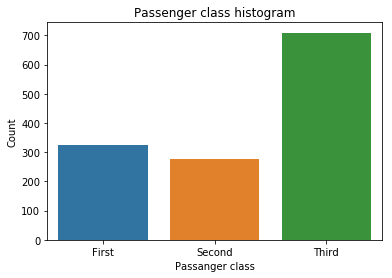

In [8]:
# Class
fig, ax = plt.subplots()
sns.countplot(x='pclass', data=data)
plt.xlim(-0.5,2.5)
plt.xlabel('Passanger class')
plt.ylabel('Count')
plt.title('Passenger class histogram')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['First', 'Second', 'Third'])
plt.show()

The most numerous group of passengers travelled on the Titanic in the third class.

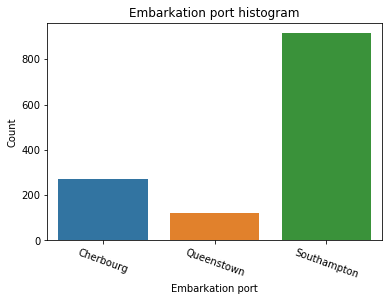

In [9]:
# Embarkation port
fig, ax = plt.subplots()
sns.countplot(x='embarked', data=data)
plt.xlim(-0.5,2.5)
plt.xlabel('Embarkation port')
plt.ylabel('Count')
plt.title('Embarkation port histogram')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Cherbourg', 'Queenstown', 'Southampton'])
plt.xticks(rotation=-20)
plt.show()

The vast majority of passengers boarded in the Southampton port.

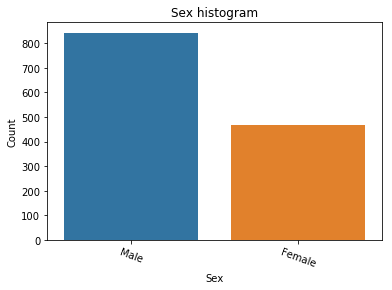

In [10]:
# Sex
fig, ax = plt.subplots()
sns.countplot(x='sex', data=data)
plt.xlim(-0.5,1.5)
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Sex histogram')
ax.set_xticks([0,1])
ax.set_xticklabels(['Male', 'Female'])
plt.xticks(rotation=-20)
plt.show()

The gender distribution on the ship suggests that the number of males dominated over the number of females. 

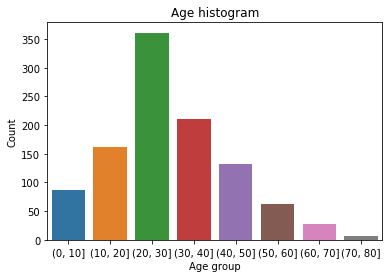

In [11]:
# Age
data['age'] = pd.cut(data['age'], [0,10,20,30,40,50,60,70,80])
fig, ax = plt.subplots()
sns.countplot(x='age', data=data)
plt.xlabel('Age group')
plt.ylabel('Count')
plt.title('Age histogram')
plt.show()

According to the age, the largest fraction of the passenger population falls in the age range between 10 and 40, with the predominant group being the one with people in the third decade of life.

After analysing the Titanic architecture plans, it has been noticed that there were a total of 9 decks on the ship out of which 8 have cabins on them and all of populated cabin fields in our data contain valid deck "symbols". 

For the third task we assume that all of the available data is correct, even though at some places there are only deck symbols while the room numbers are missing. It should be noted that some passengers have more cabins under their name and in those cases we suppose that they have reserved more cabins for them or their travel companion. 

With these assumtions we proceed as follows.

In [12]:
# Create a table with a column for every cabin that a passenger has on his name 
# (no more than 4 rooms are reserved by one passanger in our dataset)
c1 = data['cabin'].apply(lambda s: s.split(' ')[0] if not type(s) == float else None)
c2 = data['cabin'].apply(lambda s: s.split(' ')[1] if not type(s) == float and len(s.split(' ')) > 1 else None)
c3 = data['cabin'].apply(lambda s: s.split(' ')[2] if not type(s) == float and len(s.split(' ')) > 2 else None)
c4 = data['cabin'].apply(lambda s: s.split(' ')[3] if not type(s) == float and len(s.split(' ')) > 3 else None)
temp = data.join(pd.concat({'c1': c1, 'c2': c2, 'c3': c3, 'c4': c4}, axis=1))
temp.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,c1,c2,c3,c4
0,1,1,"Allen, Miss. Elisabeth Walton",female,"(20, 30]",0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",B5,None,None,None
1,1,1,"Allison, Master. Hudson Trevor",male,"(0, 10]",1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",C22,C26,None,None
2,1,0,"Allison, Miss. Helen Loraine",female,"(0, 10]",1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",C22,C26,None,None
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,"(20, 30]",1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON",C22,C26,None,None
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,"(20, 30]",1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",C22,C26,None,None


In [13]:
# We melt the different cabin columns into one and we add another column c# (cabin number) indicating the number of the reservation by user
# In the melting we use name and ticket as identity columns since none of them is unique by inself (i.e there are passengers with same name, and passengers with same ticket number, but not both)
# We also split the cabin column onto deck column (which we categorize) and a roomNo column
cabinData = pd.melt(temp[['name', 'ticket', 'c1', 'c2', 'c3', 'c4']], id_vars=['name', 'ticket'], var_name='c#', value_name='cabin')
cabinData = cabinData.join(cabinData['cabin'].str.extract('(?P<deck>[A-Z])(?P<roomNo>\d*$)', expand=True))
cabinData['deck'] = pd.Categorical(cabinData['deck'], categories=['T', 'A', 'B', 'C', 'D', 'E', 'F', 'G'], ordered=True)
cabinData.head()

,name,ticket,c#,cabin,deck,roomNo
0,"Allen, Miss. Elisabeth Walton",24160,c1,B5,B,5
1,"Allison, Master. Hudson Trevor",113781,c1,C22,C,22
2,"Allison, Miss. Helen Loraine",113781,c1,C22,C,22
3,"Allison, Mr. Hudson Joshua Creighton",113781,c1,C22,C,22
4,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",113781,c1,C22,C,22


In [14]:
# Now we are interested only in the reservations that have different decks
# i.e if a passenger X has reserved two cabins C 1 and C 2 we only count him once as him being in deck C
# also it should be noted that there are a few passenger with reservations in two different decks ex. F and E and we count them twice (once for every different deck), since we don't know in which of the two rooms they were staying
df = cabinData[~cabinData.deck.isnull()]
print("Number of cabin reservations: %d" % df.shape[0])
print("Number of cabin reservations missing a room number: %d" % cabinData[cabinData.roomNo == ''].shape[0])
df = df[['name', 'ticket', 'deck']].drop_duplicates()
print("Number of cabin reservations on different decks by passengers: %d" % df.shape[0])
df.head()

Number of cabin reservations: 356
Number of cabin reservations missing a room number: 13
Number of cabin reservations on different decks by passengers: 302


,name,ticket,deck
0,"Allen, Miss. Elisabeth Walton",24160,B
1,"Allison, Master. Hudson Trevor",113781,C
2,"Allison, Miss. Helen Loraine",113781,C
3,"Allison, Mr. Hudson Joshua Creighton",113781,C
4,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",113781,C


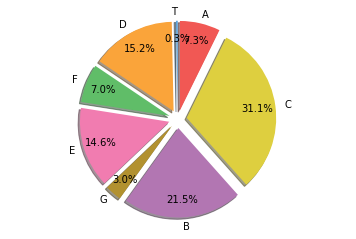

In [15]:
counts = df.deck.value_counts()
counts = counts[[7, 2, 5, 3, 6, 1, 0, 4]] # we just permute the order of the pie pieces, to make visually more distinguishable (make smallest pieces far from each other)
labels = list(counts.keys())
sizes = counts.values
explode = (0.1, 0.1, 0.1, 0.1,0.1, 0.1, 0.1, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, explode=explode, pctdistance=0.8, startangle=90, colors=["#5DA5DA", "#FAA43A", "#60BD68", "#F17CB0", "#B2912F", "#B276B2", "#DECF3F", "#F15854" ])
ax1.axis('equal')
plt.title("")
plt.show()

In order to calculate the ratio of survivors over the total number of passenger per *travel class*, an aggregation function `count` needs to be applied after the entire data is grouped according to the values of the `pclass` attribute which is the actual indicator of the travel class.

Getting the number of survivors is done by selecting only the rows that have `survived == 1` and then do the grouping by class. To the resulting dataframe, a column with the number of total passengers for each class is appended. Dividing the values in the `survived` column with the ones in `total`, gives the numeric proportion of survivors.

The following plots show 

In [38]:
survived_per_class = data[data.survived == 1].groupby('pclass', as_index=False).count()[['pclass', 'survived']]
survived_per_class['total'] = data.groupby('pclass', as_index=False).count()[['survived']]
survived_per_class['survived_proportion'] = survived_per_class['survived'] / survived_per_class['total']
survived_per_class

  pclass  survived  total  survived_proportion
0      1       200    323             0.619195
1      2       119    277             0.429603
2      3       181    709             0.255289


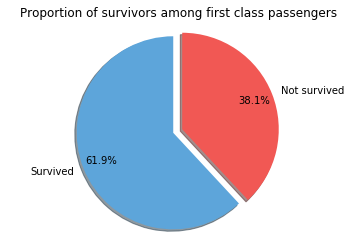

In [60]:
fig, ax = plt.subplots()

class_index = 0
plot_data = [survived_per_class.iloc[class_index]['survived'], survived_per_class.iloc[class_index]['total'] - survived_per_class.iloc[class_index]['survived']]
ax.pie(plot_data, labels=['Survived', 'Not survived'], autopct='%1.1f%%',
        shadow=True, explode=(0.1, 0.0), pctdistance=0.8, startangle=90, colors=["#5DA5DA", "#F15854"])
ax.axis('equal')
plt.title("Proportion of survivors among first class passengers")
plt.show()

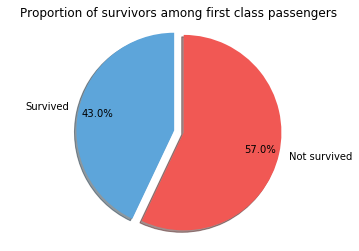

In [61]:
fig, ax = plt.subplots()

class_index = 1
plot_data = [survived_per_class.iloc[class_index]['survived'], survived_per_class.iloc[class_index]['total'] - survived_per_class.iloc[class_index]['survived']]
ax.pie(plot_data, labels=['Survived', 'Not survived'], autopct='%1.1f%%',
        shadow=True, explode=(0.1, 0.0), pctdistance=0.8, startangle=90, colors=["#5DA5DA", "#F15854"])
ax.axis('equal')
plt.title("Proportion of survivors among second class passengers")
plt.show()

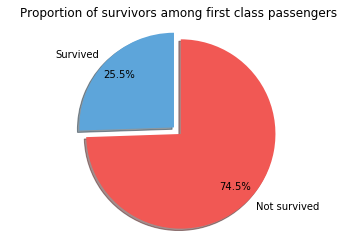

In [62]:
fig, ax = plt.subplots()

class_index = 2
plot_data = [survived_per_class.iloc[class_index]['survived'], survived_per_class.iloc[class_index]['total'] - survived_per_class.iloc[class_index]['survived']]
ax.pie(plot_data, labels=['Survived', 'Not survived'], autopct='%1.1f%%',
        shadow=True, explode=(0.1, 0.0), pctdistance=0.8, startangle=90, colors=["#5DA5DA", "#F15854"])
ax.axis('equal')
plt.title("Proportion of survivors among first class passengers")
plt.show()

In order to get the number of survivors per travel class and sex, a selection is needed that will return only those rows where `survived == 1`, which indicates the person has survived the catastrophe. After getting the subset of survivors from the original dataframe, they need to be grouped first by travel class and then by sex (or vice-versa, we'll end up with the same result), count the number of rows in each group and then just do a simple projection of the needed attributes: `pclass`, `sex`, `survived`. The `survived` field now contains the number of rows for each combination of `(pclass, sex)`.

To find the total number of people who embarked the ship per travel class and per sex, we do the same steps as before, but without asserting the condition that `survived == 1`. Then we simply divide the values of survived with the values obtained for the total number of passengers per group to obtain a value in the interval [0,1] where 0 means there were no survivors for that particular `(pclass,sex)` combination and 1 if everyone survived.

In [17]:
survived_grouped = data[data.survived == 1].groupby(['pclass', 'sex'], as_index=False).count()[['pclass', 'sex', 'survived']]
total_grouped = data.groupby(['pclass', 'sex'], as_index=False).count()[['pclass', 'sex', 'survived']]
survived_grouped['survived_proportion'] = survived_grouped['survived'] / total_grouped['survived']

survived_grouped

,pclass,sex,survived,survived_proportion
0,1,male,61,0.340782
1,1,female,139,0.965278
2,2,male,25,0.146199
3,2,female,94,0.886792
4,3,male,75,0.152130
5,3,female,106,0.490741


To be very clear on the terminology of plots, the following figure is actually a barplot and not a histogram, since a histogram requires a continuous variable along the x-axis, and what we're working with is categorical data (sex and travel class).

The travelling class is colour-coded with the colours explained in the legend field on the top right of the plot, while the two different sex categories are split into groups and indicated on the x-axis. The proportion of survived, in a range from 0.0 to 1.0, is represented on the y-axis.

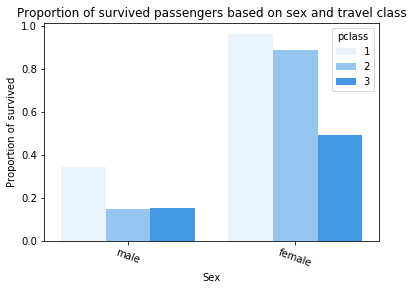

In [18]:
fig, ax = plt.subplots()
sns.barplot(x="sex", y="survived_proportion", hue="pclass", data=survived_grouped, color="#2A98FD")
plt.xlabel('Sex')
plt.ylabel('Proportion of survived')
plt.title('Proportion of survived passengers based on sex and travel class')
plt.xticks(rotation=-20)
plt.show()